# Actividad - Proyecto práctico

> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Recordad que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
* Alumno 1:
* Alumno 2: Abdelilah BENALI
* Alumno 3: Jair A Cuesta Cifuentes
* Alumno 4: Manel González Huete
* Alumno 5: Francisco Manzanas Mogrovejo

---
## **PARTE 1** - Instalación y requisitos previos

> Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la renderización en gym. Por ello, para obtener estas visualizaciones, se deberá trasladar el entorno de trabajo a local. Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. Siga los siguientes pasos para un correcto funcionamiento:
1.   **LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección *1.1.Preparar enviroment*.
2.  **AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
3. **COLAB:** se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo en Drive. Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
4.  **AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías necesarias*.


---
### 1.1. Preparar enviroment (solo local)



> Para preparar el entorno de trabajo en local, se han seguido los siguientes pasos:
1. En Windows, puede ser necesario instalar las C++ Build Tools. Para ello, siga los siguientes pasos: https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30.
2. Instalar Anaconda
3. Siguiendo el código que se presenta comentado en la próxima celda: Crear un enviroment, cambiar la ruta de trabajo, e instalar librerías básicas.


```
conda create --name miar_rl python=3.8
conda activate miar_rl
cd "PATH_TO_FOLDER"
conda install git
pip install jupyter
```


4. Abrir la notebook con *jupyter-notebook*.



```
jupyter-notebook
```


---
### 1.2. Localizar entorno de trabajo: Google colab o local

In [ ]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + "/My Drive/08_MIAR/actividades/proyecto practico"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

: 

---
### 1.3. Montar carpeta de datos local (solo Colab)

In [ ]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

---
### 1.4. Instalar librerías necesarias

In [ ]:
IN_LOCAL = True

if IN_COLAB:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.8
if not IN_LOCAL:
  %pip install numpy==1.23.5
  %pip install gym==0.17
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install pyglet==1.5.0
  %pip install h5py==3.1.0
  %pip install Pillow==9.5.0
  %pip install keras-rl2==1.0.5
  %pip install Keras==2.2.4
  %pip install tensorflow==2.5.3
  %pip install torch==2.0.1
  %pip install agents==1.4.0
  %pip install matplotlib==3.4.3
  %pip install tqdm

---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
## **PARTE 3**. Desarrollo y preguntas

### Importar librerías

In [1]:
from __future__ import division

from PIL import Image
import numpy as np
#import gymnasium as gym
import gym
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
from collections import deque
from tqdm import trange
import tensorflow.keras.backend as K

### Crear el entorno
Nuestro entorno es el juego Space Invaders, de Atari

In [2]:
# Create our environment
env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

c:\Users\User\Desktop\MASTER\1_ASIGNATURAS\08-Aprendizaje_por_Refuerzo\04_Proyecto\git\venv_apr_99\lib\site-packages\gym\logger.py:30: UserWarning: WARN: obs_type "image" should be replaced with the image type, one of: rgb, grayscale
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
print("El tamaño de nuestro 'frame' es: ", env.observation_space)
print("El número de acciones posibles es : ", nb_actions)
print("Las acciones posibles son : ",env.env.get_action_meanings())

# Here we create an hot encoded version of our actions
# possible_actions = [[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0]...]
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())
print("\nOHE de las acciones posibles: \n", possible_actions)

El tamaño de nuestro 'frame' es:  Box(0, 255, (210, 160, 3), uint8)
El número de acciones posibles es :  6
Las acciones posibles son :  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

OHE de las acciones posibles: 
 [[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


### Definición Hiperparámetros

In [4]:
### HIPERPARÁMETROS DEL MODELO
INPUT_SHAPE = (84, 84)
state_size = [84, 84, 4]          # Nuestra entrada es una pila de 4 fotogramas, por lo tanto 110x84x4 (ancho, alto, canales)
action_size = env.action_space.n  # 6 acciones posibles
learning_rate =  0.00025          # Alfa (también conocido como tasa de aprendizaje)

### HIPERPARÁMETROS DE ENTRENAMIENTO
# total_episodios = 10    #TEST        # Episodios totales para el entrenamiento
# max_steps = 10000       #TEST        # Máximo de pasos posibles por episodio
total_episodios = 50           # Episodios totales para el entrenamiento
max_steps = 50000              # Máximo de pasos posibles por episodio
batch_size = 32                # Tamaño del lote (batch)

# Parámetros de exploración para la estrategia epsilon-greedy
epsilon_start = 1.0            # Probabilidad de exploración al inicio
epsilon_stop = 0.01            # Probabilidad mínima de exploración
decay_rate = 0.00001           # Tasa de decaimiento exponencial para la probabilidad de exploración
epsilon_decay = 0.995

# Hiperparámetros del aprendizaje Q
gamma = 0.95                   # Tasa de descuento
tau = 0.001

### HIPERPARÁMETROS DE MEMORIA
pretrain_length = batch_size   # Número de experiencias almacenadas en la memoria al inicializar por primera vez
memory_size = 20000            # Número de experiencias que la memoria puede guardar

### HIPERPARÁMETROS DE PREPROCESAMIENTO
WINDOW_LENGTH = 4              # Número de fotogramas apilados

### CAMBIA ESTO A FALSE SI SOLO QUIERES VER AL AGENTE ENTRENADO
training = False

## CAMBIA ESTO A TRUE SI QUIERES RENDERIZAR EL ENTORNO
episode_render = False

### Clase "processor" para Atari

Ahora definimos un "processor" para las pantallas de entrada del juego, en el que recortamos el tamaño de la imagen (matriz de 210 x 160 píxeles) y la convertimos En una matriz bidimensional de 80 x 80 píxeles). También convertimos las imágenes de RGB a escala de grises normal, ya que no necesitamos usar los colores. Con este trabajo buscamos acelerar nuestro algoritmo, eliminando la información innecesaria y reduciendo la carga de la GPU.

In [5]:
from rl.core import Processor

class AtariProcessor(Processor):
    def process_observation(self, observation):
        """
        Preprocesamiento simple: convierte a escala de grises y normaliza
        """
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

### Revisar el entorno de juego

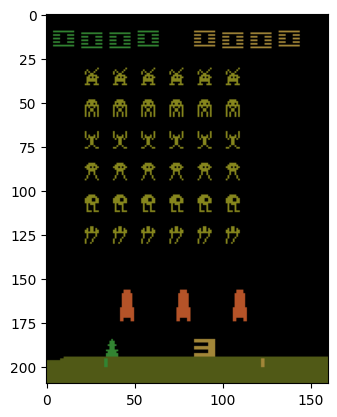

In [6]:
import matplotlib.pyplot as plt

observation = env.reset()
for i in range(22): 
  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, reward, done, info = env.step(1)

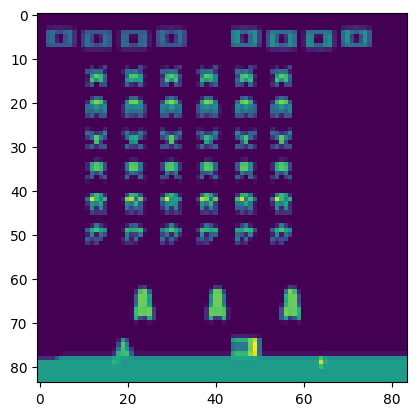

(210, 160, 3)
(84, 84)


In [7]:
# Mostrar las entradas preprocesadas en escala de grises y comparar originales y preprocesados.
processor = AtariProcessor()
obs_preprocessed = processor.process_observation(observation).reshape(INPUT_SHAPE)
plt.imshow(processor.process_state_batch(obs_preprocessed))
plt.show()
print(observation.shape)
print(obs_preprocessed.shape)

1. Implementación de la red neuronal

Crearemos una clase para construir un red Q-profunda, con tres capas convolucionales, seguidas de una capa de aplanamiento y una capa completamente conectada.

In [8]:
class DQNetwork(tf.keras.Model):
    """
    Red neuronal Deep Q-Network (DQN) para aproximar la función Q en aprendizaje por refuerzo.

    Esta clase implementa una red convolucional que recibe un estado (conjunto de frames)
    y produce los valores Q para cada acción posible. Usa capas convolucionales seguidas
    de capas totalmente conectadas, con activación ELU.

    Parámetros:
    -----------
    state_size : tupla/lista - Dimensiones del estado de entrada (por ejemplo, [84, 84, 4]).
    action_size : int        - Número de acciones posibles en el entorno.
    learning_rate : float    - Tasa de aprendizaje para el optimizador Adam.
    name : str, opcional     - Nombre del scope de TensorFlow para distinguir múltiples redes.
    """
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        super(DQNetwork, self).__init__(name=name)
        
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

        # Primera capa convolucional con activación ELU
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(8,8), strides=(4,4) ,
                                            padding='same', activation='elu',
                                            kernel_initializer='glorot_uniform')  # (84, 84, 4)
        # Segunda capa convolucional con activación ELU
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(2,2),
                                            padding='same', activation='elu',
                                            kernel_initializer='glorot_uniform')
        # Tercera capa convolucional con activación ELU
        self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),
                                            padding='same', activation='elu',
                                            kernel_initializer='glorot_uniform')
        # Aplanar la salida de la última convolucional
        self.flatten = tf.keras.layers.Flatten()
        # Capa completamente conectada con activación ELU
        self.fc = tf.keras.layers.Dense(units=512, activation='elu',
                                        kernel_initializer='glorot_uniform')
        # Capa de salida que devuelve valores Q para cada acción
        self.output_layer = tf.keras.layers.Dense(units=self.action_size,
                                                  activation=None,
                                                  kernel_initializer='glorot_uniform')

        # Definir el optimizador
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Definir la función de pérdida (error cuadrático medio)
        self.loss_fn = tf.keras.losses.MeanSquaredError()
        self.compile(optimizer=self.optimizer, loss=self.loss_fn)

    def call(self, inputs):
        """
        Ejecuta la red neuronal para un batch de estados y define la lógica para hacer la propagación hacia adelante 
        (forward pass).  Se llama automáticamente en una clase que hereda de tf.keras.Model o tf.keras.layers.Layer.

        Parámetros:
        -----------
        inputs : tf.Tensor  - Tensor con los estados de entrada, shape = (batch_size, *state_size)

        Retorna:
        --------
        tf.Tensor - Valores Q para cada acción, shape = (batch_size, action_size)
        """
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc(x)
        q_values = self.output_layer(x)
        return q_values

    @tf.function    
    def train_step(self, states, actions, target_q):
        """
        Realiza un paso de entrenamiento: calcula la pérdida y aplica gradientes.

        Parámetros:
        -----------
        states : tf.Tensor -    Batch de estados de entrada, shape = (batch_size, *state_size)
        actions : tf.Tensor -   Acciones tomadas, codificadas one-hot, shape = (batch_size, action_size)
        target_q : tf.Tensor -  Valores objetivo Q, shape = (batch_size,)

        Retorna:
        --------
        loss : tf.Tensor -      Valor de la pérdida calculada en este paso.
        """
        with tf.GradientTape() as tape:
            q_values = self.call(states)  # Salida con valores Q para todas las acciones
            # Obtenemos Q para las acciones tomadas multiplicando por la máscara one-hot y sumando
            q_action = tf.reduce_sum(q_values * actions, axis=1)
            # Si target_q es (batch_size, num_actions), entonces:
            target_q_action = tf.reduce_sum(tf.expand_dims(target_q, axis=1) * actions, axis=1)            
            # Calculamos la pérdida MSE entre Q predicho y target_Q
            loss = self.loss_fn(target_q_action, q_action)

        # Calculamos los gradientes y actualizamos los pesos
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss

In [9]:
class DDQNetwork(tf.keras.Model):
    """
    Double Deep Q-Network (DDQN) para reducir la sobreestimación en DQN.
    
    DDQN usa dos redes: una principal (main) y una objetivo (target).
    La red principal selecciona las acciones, mientras que la red objetivo
    evalúa los valores Q, reduciendo así el sesgo de sobreestimación.

    Parámetros:
    -----------
    state_size : tupla/lista - Dimensiones del estado de entrada (por ejemplo, [84, 84, 4]).
    action_size : int        - Número de acciones posibles en el entorno.
    learning_rate : float    - Tasa de aprendizaje para el optimizador Adam.
    tau : float, opcional    - Factor de actualización suave para la red objetivo (default: 0.001).
    name : str, opcional     - Nombre del scope de TensorFlow.
    """
    def __init__(self, state_size, action_size, learning_rate, tau=0.001, name='DDQNetwork'):
        super(DDQNetwork, self).__init__(name=name)
        
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.tau = tau
        
        # Red principal (main network)
        self.main_network = self._crear_red('main')
        # Red objetivo (target network)
        self.target_network = self._crear_red('target')
        
        # Construir ambas redes con la forma de entrada correcta
        input_shape = (None,) + tuple(state_size)  # (None, 84, 84, 4)
        self.main_network.build(input_shape)
        self.target_network.build(input_shape)        
        
        # Definir optimizador y función de pérdida
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.loss_fn = tf.keras.losses.MeanSquaredError()
        
        # Inicializar la red objetivo con los mismos pesos que la principal
        self.update_target_network(tau=1.0)
        
    def _crear_red(self, network_name):
        """
        Construye una red individual con la arquitectura DQN.
        
        Parámetros:
        -----------
        network_name : str - Nombre identificador de la red ('main' o 'target').
        
        Retorna:
        --------
        tf.keras.Sequential - Red neuronal construida.
        """
        return tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=32, kernel_size=(8,8), strides=(4,4),
                                 padding='same', activation='elu',
                                 kernel_initializer='glorot_uniform',
                                 name=f'{network_name}_conv1'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(2,2),
                                 padding='same', activation='elu',
                                 kernel_initializer='glorot_uniform',
                                 name=f'{network_name}_conv2'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),
                                 padding='same', activation='elu',
                                 kernel_initializer='glorot_uniform',
                                 name=f'{network_name}_conv3'),
            tf.keras.layers.Flatten(name=f'{network_name}_flatten'),
            tf.keras.layers.Dense(units=512, activation='elu',
                                kernel_initializer='glorot_uniform',
                                name=f'{network_name}_fc'),
            tf.keras.layers.Dense(units=self.action_size, activation=None,
                                kernel_initializer='glorot_uniform',
                                name=f'{network_name}_output')
        ], name=f'{network_name}_network')
        
    def call(self, inputs, training=True):
        """
        Propagación hacia adelante usando la red principal.
        
        Parámetros:
        -----------
        inputs : tf.Tensor - Estados de entrada, shape = (batch_size, *state_size)
        training : bool    - Si está en modo entrenamiento (default: True)
        
        Retorna:
        --------
        tf.Tensor - Valores Q de la red principal, shape = (batch_size, action_size)
        """
        return self.main_network(inputs, training=training)        
    

    def get_target_q_values(self, inputs):
        """
        Obtiene los valores Q de la red objetivo.
        
        Parámetros:
        -----------
        inputs : tf.Tensor - Estados de entrada, shape = (batch_size, *state_size)
        
        Retorna:
        --------
        tf.Tensor - Valores Q de la red objetivo, shape = (batch_size, action_size)
        """
        return self.target_network(inputs, training=False)
    
    def update_target_network(self, tau=None):
        """
        Actualiza la red objetivo usando actualización suave (soft update).
        
        θ_target = τ * θ_main + (1 - τ) * θ_target
        
        Parámetros:
        -----------
        tau : float, opcional - Factor de actualización. Si es None, usa self.tau.
        """
        if tau is None:
            tau = self.tau
            
        main_weights = self.main_network.get_weights()
        target_weights = self.target_network.get_weights()
        
        updated_weights = []
        for main_w, target_w in zip(main_weights, target_weights):
            updated_w = tau * main_w + (1 - tau) * target_w
            updated_weights.append(updated_w)
            
        self.target_network.set_weights(updated_weights)    
        
    @tf.function        
    def train_step(self, states, actions, rewards, next_states, dones, gamma=0.99):
        """
        Realiza un paso de entrenamiento DDQN.
        
        En DDQN:
        1. La red principal selecciona la mejor acción para next_states
        2. La red objetivo evalúa el valor Q de esa acción
        3. Se calcula el target Q usando la ecuación de Bellman
        
        Parámetros:
        -----------
        states : tf.Tensor     - Estados actuales, shape = (batch_size, *state_size)
        actions : tf.Tensor    - Acciones tomadas (one-hot), shape = (batch_size, action_size)
        rewards : tf.Tensor    - Recompensas obtenidas, shape = (batch_size,)
        next_states : tf.Tensor- Siguientes estados, shape = (batch_size, *state_size)
        dones : tf.Tensor      - Flags de episodio terminado, shape = (batch_size,)
        gamma : float          - Factor de descuento (default: 0.99)
        
        Retorna:
        --------
        loss : tf.Tensor - Valor de la pérdida calculada en este paso.
        """
        with tf.GradientTape() as tape:
            # Valores Q actuales de la red principal
            current_q_values = self.main_network(states, training=True)
            current_q_action = tf.reduce_sum(current_q_values * actions, axis=1)
            
            # DDQN: Red principal selecciona acciones, red objetivo las evalúa
            next_q_values_main = self.main_network(next_states, training=True)
            next_actions = tf.one_hot(tf.argmax(next_q_values_main, axis=1), self.action_size)
            
            next_q_values_target = self.target_network(next_states, training=False)
            next_q_action = tf.reduce_sum(next_q_values_target * next_actions, axis=1)
            
            # Calcular target Q usando ecuación de Bellman
            target_q = rewards + gamma * next_q_action * (1.0 - tf.cast(dones, tf.float32))
            
            # Calcular pérdida MSE
            loss = self.loss_fn(target_q, current_q_action)
        
        # Aplicar gradientes solo a la red principal
        gradients = tape.gradient(loss, self.main_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.main_network.trainable_variables))
        
        return loss        

2. Implementación de la solución DQN

In [10]:
class FrameStack:
    """
    Clase para apilar frames consecutivos
    """
    def __init__(self, num_frames=4):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)
    
    def reset(self):
        self.frames.clear()
    
    def add_frame(self, frame):
        # Si es el primer frame, llenamos el deque
        if len(self.frames) == 0:
            for _ in range(self.num_frames):
                self.frames.append(frame)
        else:
            self.frames.append(frame)
    
    def get_state(self):
        # Convertir a array con shape (84, 84, 4)
        return np.stack(self.frames, axis=-1)

In [11]:
def preprocess_state(state, processor, frame_stack):
    """
    Preprocess a single state using AtariProcessor and FrameStack
    """
    processed_frame = processor.process_observation(state)
    frame_stack.add_frame(processed_frame)
    state = frame_stack.get_state()
    return processor.process_state_batch(np.expand_dims(state, 0))[0]

In [ ]:
import tensorflow.python.ops.numpy_ops.np_config as np_config

# Habilitar comportamiento NumPy para tensores de TensorFlow
np_config.enable_numpy_behavior()

# Asegurar que la ejecución eager esté habilitada desde el inicio
tf.config.run_functions_eagerly(True)


def simple_train(env,dqnet_class, processor, epsilon_start,total_episodios):
    """
    Entrenamiento simple con tu red DQN
    """
    # Limpiar cualquier grafo anterior
    tf.keras.backend.clear_session()
    
    print(f"[DEBUG] - Configuración:")
    print(f"  - State size: {state_size}")
    print(f"  - Action size: {action_size}")
    print(f"  - Learning rate: {learning_rate}")
    print(f"  - Gamma: {gamma}")
    print(f"  - TensorFlow eager: {tf.executing_eagerly()}")

    # Debug TensorFlow and Keras versions
    print(f"[DEBUG] - TensorFlow version: {tf.__version__}")
    import keras
    print(f"[DEBUG] - Keras version: {keras.__version__}")
    
    # Crear la red - FORZAR state_size a 4 canales para frame stacking
    print(f"[DEBUG] - Tamaño original del estado (state_size): {state_size}")  # DEBUG
    dqnet = dqnet_class(state_size, action_size, learning_rate)
    # Construir explícitamente el modelo con la forma de entrada esperada
    # La forma de entrada al método 'call' del modelo es (batch_size, 84, 84, 4)
    # Para build, usamos (None, 84, 84, 4) donde None representa el tamaño del lote.
    # No necesitamos build aquí porque DDQNetwork ya lo hace en __init__
    
    # Construir el modelo con la forma de entrada correcta
    input_shape = (None,) + tuple(state_size)  # (None, 84, 84, 4)
    dqnet.build(input_shape)
    print(dqnet.summary())

    print("[DEBUG] - Información de la red:\n")  # DEBUG

    # -----------------------
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.MeanSquaredError()    
    print(f"[DEBUG] - Red creada correctamente\n\n")  # DEBUG
 
    scores = []

    for episode in trange(total_episodios, desc="Training"):
        observation = env.reset()
        frame_stack = FrameStack(WINDOW_LENGTH)
        state = preprocess_state(observation, processor, frame_stack)
       
        total_reward = 0
        steps = 0
        
        while steps < max_steps:
            # Selección epsilon-greedy
            if np.random.random() <= epsilon_start:
                action = env.action_space.sample()
            else:
                # Método más robusto para obtener acción
                state_input = tf.convert_to_tensor(np.expand_dims(state, axis=0), dtype=tf.float32)
                q_values = dqnet(state_input, training=False)
                # action = tf.argmax(q_values[0]).numpy()        
                # Evaluate tensor in graph mode
                action = tf.keras.backend.get_value(tf.argmax(q_values[0]))
                #action = tf.argmax(q_values[0]).numpy()

                                
            # Ejecutar acción
            next_observation, reward, done, _ = env.step(action)            
            # Procesar siguiente estado       
            next_state = preprocess_state(next_observation, processor, frame_stack)
            # Procesar reward (clip entre -1 y 1)
            reward = processor.process_reward(reward)     

            # Calcular Q-value Objetivo
            next_state_tf = tf.convert_to_tensor(np.expand_dims(next_state, axis=0), dtype=tf.float32)   
            # Preparar tensores para entrenamiento
            states_tf = tf.convert_to_tensor(np.expand_dims(state, axis=0), dtype=tf.float32)
            actions_onehot = tf.one_hot([action], action_size)

            prefijo = ""
            if dqnet_class == DDQNetwork:
                # DDQN: Usar train_step interno con lógica DDQN
                loss = dqnet.train_step(states_tf, actions_onehot, reward, next_state_tf, done, gamma)
                # Actualizar red objetivo
                dqnet.update_target_network()
                prefijo="DDQN"
            else:
                # DQN: Calcular Q-valor objetivo manualmente
                next_q_vals = dqnet(next_state_tf, training=False)
                # max_next_q = tf.reduce_max(next_q_vals[0]).numpy()
                # max_next_q = tf.keras.backend.get_value(tf.reduce_max(next_q_vals[0], axis=1))
                max_next_q = tf.keras.backend.get_value(tf.reduce_max(next_q_vals[0]))
                target_q_value = reward + gamma * max_next_q * (1.0 - float(done))      
                target_q_tensor = tf.convert_to_tensor([target_q_value], dtype=tf.float32)                
                # Entrenamiento usando método interno
                loss = dqnet.train_step(states_tf, actions_onehot, target_q_tensor)
                prefijo="DQN"

            # Actualizar estado
            state = next_state
            total_reward += reward
            steps += 1

            if steps % 100 == 0:
                print(f"  [INFO] - Ep {episode:3d} Step {steps:3d}: Training active")
            if done:
                break
 
        # Actualizar epsilon
        if epsilon_start > epsilon_stop:
            epsilon_start *= epsilon_decay
        
        scores.append(total_reward)
        avg_score = np.mean(scores[-10:]) if len(scores) >= 10 else np.mean(scores)
        
        print(f"\n📊 Episodio {episode + 1}/{total_episodios}")
        print(f"   Score: {total_reward:.1f} | Steps: {steps}")
        print(f"   Epsilon: {epsilon_start:.3f} | Avg Score: {avg_score:.2f}")
        print("-" * 40)

        # Guardar cada 10 episodios
        if (episode + 1) % 10 == 0:
            try:
                checkpoint_path = f'{prefijo}_checkpoint_ep{episode + 1}.h5'
                dqnet.save_weights(checkpoint_path)
                print(f"💾 Guardado: {checkpoint_path}")
            except Exception as e:
                print(f"⚠️  Error guardando: {e}")    

        # Al final del bucle de episodios
        gc.collect()

    env.close()    
    print("\n🎯 Entrenamiento completado!")
    return dqnet

In [13]:
def test_simple(trained_model, processor, episodes=3, render=False, max_steps=1000):
    """
    Probar la red entrenada (DQN o DDQN) en el entorno SpaceInvaders-v0.

    Args:
        trained_model: tf.keras.Model - Modelo entrenado (DQNetwork o DDQNetwork).
        processor: AtariProcessor -     Procesador para preprocesar observaciones.
        episodes: int -                 Número de episodios de prueba.
        max_steps: int -                Máximo de pasos por episodio.
        render: bool -                  Si se debe renderizar el entorno.

    Returns:
        float: Promedio de recompensa en los episodios de prueba.
    """
    env = gym.make('SpaceInvaders-v0')
    frame_stack = FrameStack(WINDOW_LENGTH)
    scores = []    
    
    # Imprimir información de depuración
    model_type = 'DDQNetwork' if trained_model.__class__.__name__ == 'DDQNetwork' else 'DQNetwork'
    print(f"[DEBUG] - Probando modelo: {model_type}")
    print(f"[DEBUG] - Episodios de prueba: {episodes}, Max pasos: {max_steps}, Render: {render}\n")    
    
    for episode in range(episodes):
        observation = env.reset()
        state = preprocess_state(observation, processor, frame_stack)
        total_reward = 0
        steps = 0
        
        while steps < max_steps:
            if render:
                env.render()
            
            # Sin exploración - solo usar la red
            state_tensor = tf.convert_to_tensor(np.expand_dims(state, axis=0), dtype=tf.float32)
            q_values = trained_model(state_tensor, training=False)
            action = np.argmax(q_values[0])
            
            next_observation, reward, done, _ = env.step(action)
            state = preprocess_state(next_observation, processor, frame_stack)
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        scores.append(total_reward)
        print(f"Episodio de prueba {episode + 1}: Score = {total_reward}, Steps = {steps}")
    
    avg_test_score = np.mean(scores)
    print(f"\nPromedio de recompensa en {episodes} episodios de prueba: {avg_test_score:.2f}")
    
    env.close()
    return avg_test_score

    2.1 Ejecución de los modelos

In [14]:
# Función de utilidad para crear y comparar los modelos que se vayan creando
def crear_modelo(model_type, state_size, action_size, learning_rate=0.001, **kwargs):
    """
    Factory function para crear modelos DQN o DDQN.
    
    Parámetros:
    -----------
    model_type :    str - Tipo de modelo: 'DQN' o 'DDQN'
    state_size :    tupla - Dimensiones del estado
    action_size :   int - Número de acciones
    learning_rate : float - Tasa de aprendizaje
    **kwargs : dict - Argumentos adicionales específicos del modelo
    
    Retorna:
    --------
    DQNetwork o DDQNetwork - Modelo creado según el tipo especificado
    """
    # Crear el procesador Atari
    processor = AtariProcessor()
    
    print("-" * 60)  
    if model_type.upper() == 'DQN':
        print("Entrenando DQN simple para Space Invaders...")
        # Entrenar -------------------------------------
        trained_dqn = simple_train(env,DQNetwork, processor, epsilon_start,total_episodios)
    elif model_type.upper() == 'DDQN':
        print("Entrenando DDQN simple para Space Invaders...")    
        trained_dqn = simple_train(env,DDQNetwork, processor, epsilon_start,total_episodios)        
    else:
        raise ValueError("model_type debe ser 'DQN' o 'DDQN'")

    print("-" * 60)       

    return trained_dqn


In [ ]:
import random

if __name__ == "__main__":   
    # Limpiar cualquier grafo anterior
    tf.keras.backend.clear_session()
    # Enable NumPy behavior and force eager execution at the start
    np_config.enable_numpy_behavior()
    # Habilitar eager execution para poder usar .numpy()
    tf.config.run_functions_eagerly(True)
    print("[INFO] - Eager execution habilitado")

    with tf.device('/GPU:0'):
        # Crear modelo DQN
        trained_dqn_model = crear_modelo('DQN', state_size, action_size, learning_rate)
        trained_dqn_model.save_weights('dqn_final.h5')
        print("Modelo DQN creado")
        
        # Crear modelo DDQN
        trained_ddqn_model = crear_modelo('DDQN', state_size, action_size, learning_rate, tau=tau)
        trained_ddqn_model.save_weights('ddqn_final.h5')
        print("Modelo DDQN creado")
    
        # Probar
        print("\nProbando DQN entrenada...")
        test_simple(trained_model=trained_dqn_model, processor=processor, episodes=5, render=episode_render)
        
        print("\nProbando DDQN entrenada...")
        test_simple(trained_model=trained_ddqn_model, processor=processor, episodes=5, render=episode_render)    

[INFO] - Eager execution habilitado
------------------------------------------------------------
Entrenando DQN simple para Space Invaders...
[DEBUG] - Configuración:
  - State size: [84, 84, 4]
  - Action size: 6
  - Learning rate: 0.00025
  - Gamma: 0.95
  - TensorFlow eager: False
[DEBUG] - TensorFlow version: 2.8.4
[DEBUG] - Keras version: 2.8.0
[DEBUG] - Tamaño original del estado (state_size): [84, 84, 4]
Model: "DQNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  8224      
                                                                 
 conv2d_1 (Conv2D)           multiple                  32832     
                                                                 
 conv2d_2 (Conv2D)           multiple                  36928     
                                                                 
 flatten (Flatten)           multiple 

Training:   0%|          | 0/50 [00:00<?, ?it/s]

  [INFO] - Ep   0 Step 100: Training active
  [INFO] - Ep   0 Step 200: Training active
  [INFO] - Ep   0 Step 300: Training active


Training:   2%|▏         | 1/50 [03:14<2:38:35, 194.20s/it]


📊 Episodio 1/50
   Score: 3.0 | Steps: 302
   Epsilon: 0.995 | Avg Score: 3.00
----------------------------------------
  [INFO] - Ep   1 Step 100: Training active
  [INFO] - Ep   1 Step 200: Training active
  [INFO] - Ep   1 Step 300: Training active
  [INFO] - Ep   1 Step 400: Training active


Training:   4%|▍         | 2/50 [26:04<11:48:57, 886.19s/it]


📊 Episodio 2/50
   Score: 12.0 | Steps: 496
   Epsilon: 0.990 | Avg Score: 7.50
----------------------------------------
  [INFO] - Ep   2 Step 100: Training active
  [INFO] - Ep   2 Step 200: Training active
  [INFO] - Ep   2 Step 300: Training active
  [INFO] - Ep   2 Step 400: Training active


Training:   6%|▌         | 3/50 [1:20:18<25:41:00, 1967.24s/it]


📊 Episodio 3/50
   Score: 9.0 | Steps: 462
   Epsilon: 0.985 | Avg Score: 8.00
----------------------------------------
  [INFO] - Ep   3 Step 100: Training active
  [INFO] - Ep   3 Step 200: Training active
  [INFO] - Ep   3 Step 300: Training active
  [INFO] - Ep   3 Step 400: Training active


3. Justificación de los parámetros seleccionados y de los resultados obtenidos

---